# Coursera Capstone Project

In Coursera we work with real datasets to get experience of what a real data scientist go through in the real life.Objectives of the final assignments were to define a business problem, look for data in the web and, use Foursquare location data to compare different neighborhoods of NewYork city to figure out which neighborhood is suitable for starting a new Indian restaurant . In this project, I go through all the process in a step by step manner from problem designing, data preparation to final analysis and finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.

## 1. Description of the Problem and Discussion of the Background (Introduction Section)


#### Prospects of opening an Indian restaurant in New York city:

   New York City comprises 5 boroughs sitting where the Hudson River meets the Atlantic Ocean. At its core is Manhattan, a densely populated borough that’s among the world’s major commercial, financial and cultural centers. Its iconic sites include skyscrapers such as the Empire State Building and sprawling Central Park. Broadway theater is staged in neon-lit Times Square.
   In this project we will go through a step bey step process to decide where to open an Indian restaurant.We will analyse the real dataset of neighborhoods in New York City to identify the correct and profitable place for an Indian restaurant.


#### Target Audience
 
Who will be more interested in this project?And who will be benefitted more?

1.Business personnel who wants to invest or open an Indian restaurant in New York city. This analysis will be a comprehensive guide to start or expand restaurants targeting the Indian crowd.

2.Freelancer who loves to have their own restaurant as a side business. This analysis will give an idea, how beneficial it is to open a restaurant and what are the pros and cons of this business.

3.Indian crowd who wants to find neighborhoods with lots of option for Indian restaurants.

4.Business Analyst or Data Scientists, who wish to analyze the neighborhoods of New York using Exploratory Data Analysis and other statistical & machine learning techniques to obtain all the necessary data, perform some operations on it and, finally be able to tell a story out of it.



## 2.Data Acuisition and Data cleaning

#### Data Sources:
1)'https://data.cityofnewyork.us/api/views/xyye-rtrs/rows.csv?accessType=DOWNLOAD'

We are using the above csv file to locate the neighborhoods in New York city. This data is extracted from https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

2) To get location and other information about various stores in Washington I’m using Foursquare’s explore API. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in  and collected their names, categories and locations (latitude and longitude). From Foursquare API (https://developer.foursquare.com/docs), I retrieved the following for each venue:

Name: The name of the venue.

Category: The category type as defined by the API.

Latitude: The latitude value of the venue.

Longitude: The longitude value of the venue.




#### import the required libraries.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## Importing,Exploring,Wrangling and Cleaning data

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.



In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.



In [13]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'KLY2EGLK2ZJ3FZPQQRKW55MGUEZTT1RVCFOMNX14NLTDCYYA' # your Foursquare ID
    CLIENT_SECRET = 'ZTFQO4YNV0JZEYIDRE42IPCIRJLK4TWSOGLEEHQ4QXPEGO5I' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.



In [14]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'KLY2EGLK2ZJ3FZPQQRKW55MGUEZTT1RVCFOMNX14NLTDCYYA' # your Foursquare ID
    CLIENT_SECRET = 'ZTFQO4YNV0JZEYIDRE42IPCIRJLK4TWSOGLEEHQ4QXPEGO5I' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.



In [15]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


We will call the above funtion to get the new york city data.



In [16]:
new_york_data=get_new_york_data()


In [17]:
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [18]:
new_york_data.shape


(306, 4)

So there are total of 306 different Neighborhoods in New York



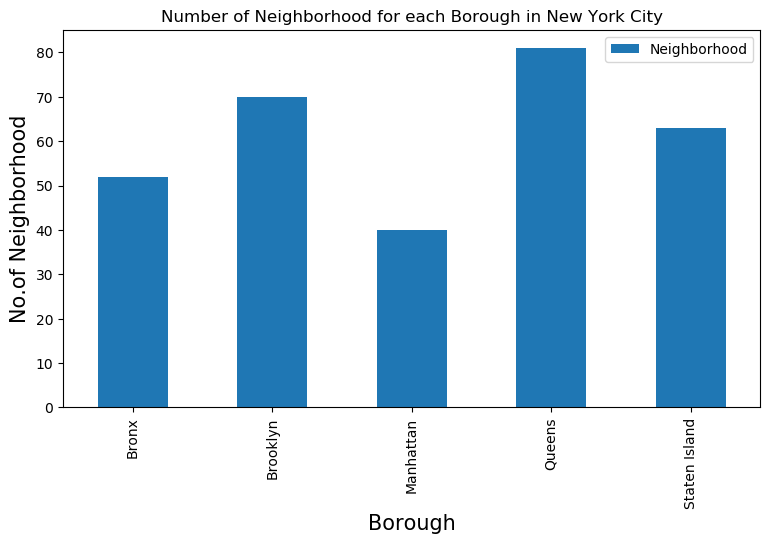

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


We see that Queens has highest number of neighborhoods

Now we will collect Indian resturants for each Neighborhood

In [20]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

Now that we have got all the indian resturants in new york city , we will analyze it



In [21]:
indian_rest_ny.head()


,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [22]:
indian_rest_ny.shape


(146, 4)

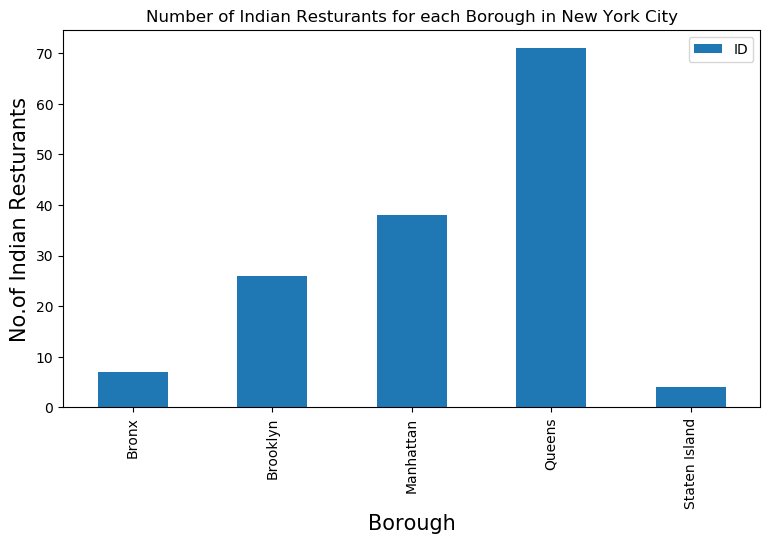

In [23]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


We see that Queens has the largest number of indian resturants



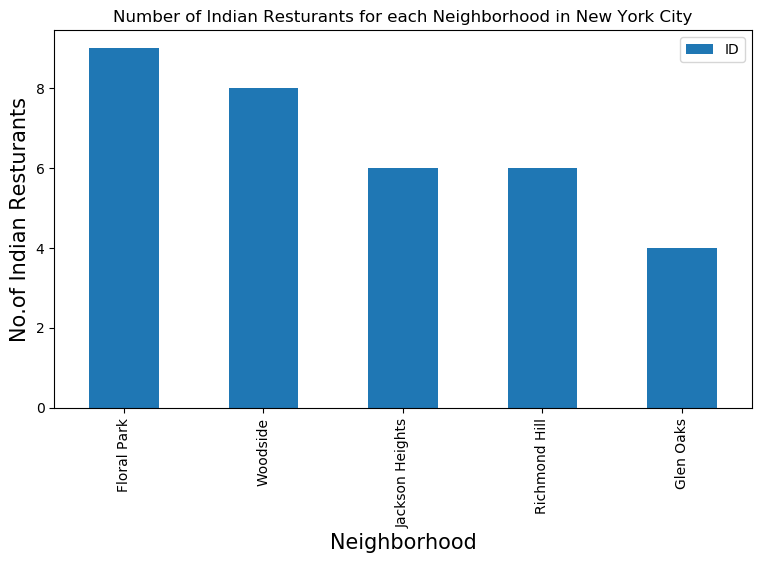

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [25]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']


,Borough,Neighborhood,ID,Name
99,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
100,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
101,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
102,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
103,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
104,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
105,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
106,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
107,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Floral Park in Queens has the highest number of Indian Resturants with a total count of 9.

Now we will get the ranking of each resturant for further analysis.